<img src = 'https://amelie-style.ru/wp-content/uploads/2022/12/dokumenty-na-strahovku.jpg'>

# <center> Проект. Предсказание расходов по медицинской страховке. Задача регрессии

## <center> 1. Загрузка и первичный анализ данных

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [2]:
data = pd.read_csv('F:\IDE\SkillFactory\ML-2_Обучение с учителем_Регрессия\insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

* age — возраст страхователя;
* sex — пол;
* bmi — индекс массы тела (кг/м$^2$), в идеале — от 18.5 до 24.9;
* children — количество детей, охваченных медицинской страховкой;
* smoker — является ли человек курящим;
* region — район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад);
* charges (**целевой признак**) — индивидуальные медицинские расходы, оплачиваемые медицинской страховкой.

Размер таблицы:

In [3]:
print(data.shape)

(1338, 7)


In [4]:
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [5]:
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

* age, bmi, children — числовые признаки;
* sex, smoker — бинарные категориальные переменные (две категории);
* region — множественные категориальные переменные (несколько категорий);
* charges — числовой целевой признак.

In [6]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

## <center> 2. Разведывательный анализ данных

Посмотрим на распределение числовых признаков

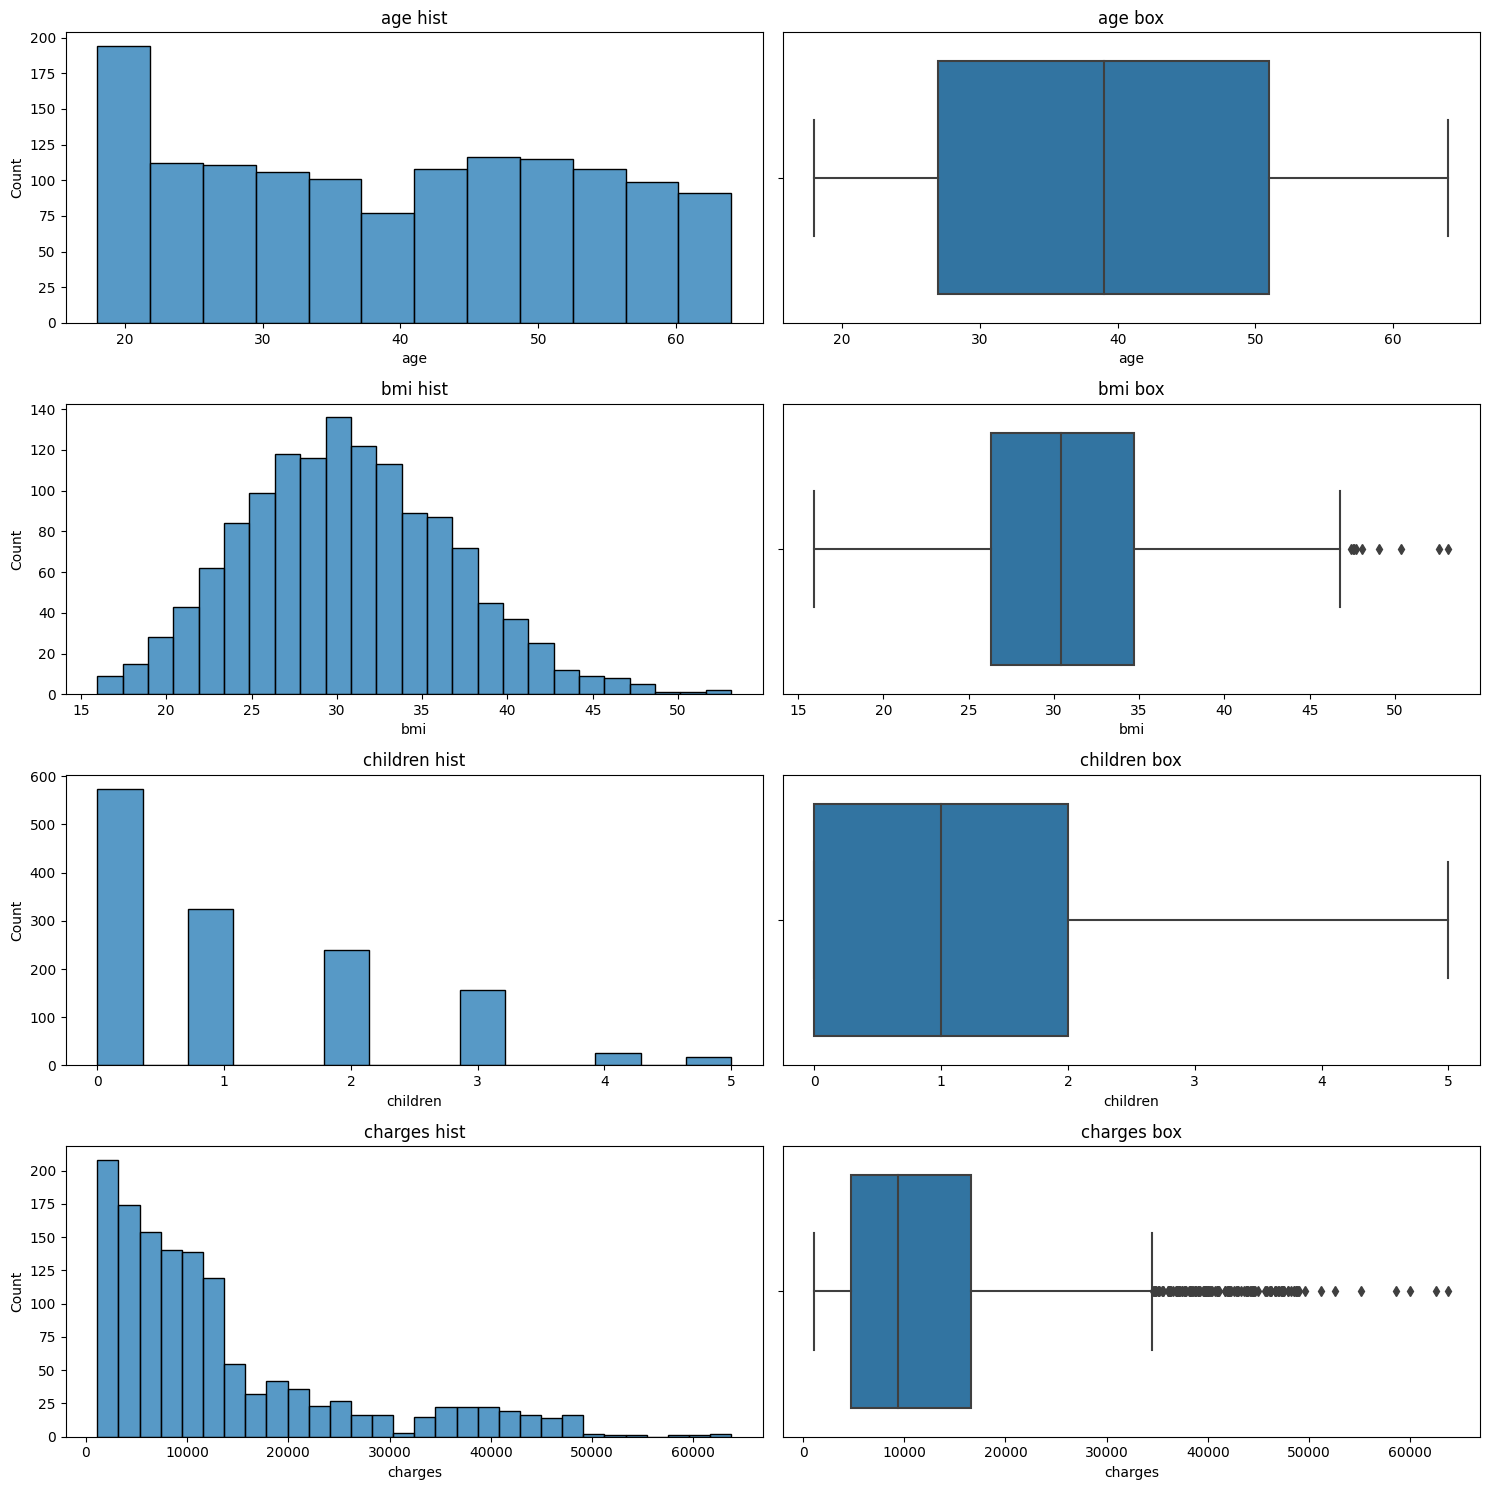

In [14]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 15)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Строим коробчатую диаграмму распределения признака 
    boxplot = sns.boxplot(data=data, x=feature, ax=axes[i][1])
    #Добавляем подпись графику
    boxplot.set_title('{} box'.format(feature));
    
plt.tight_layout() #выравнивание графиков

столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков

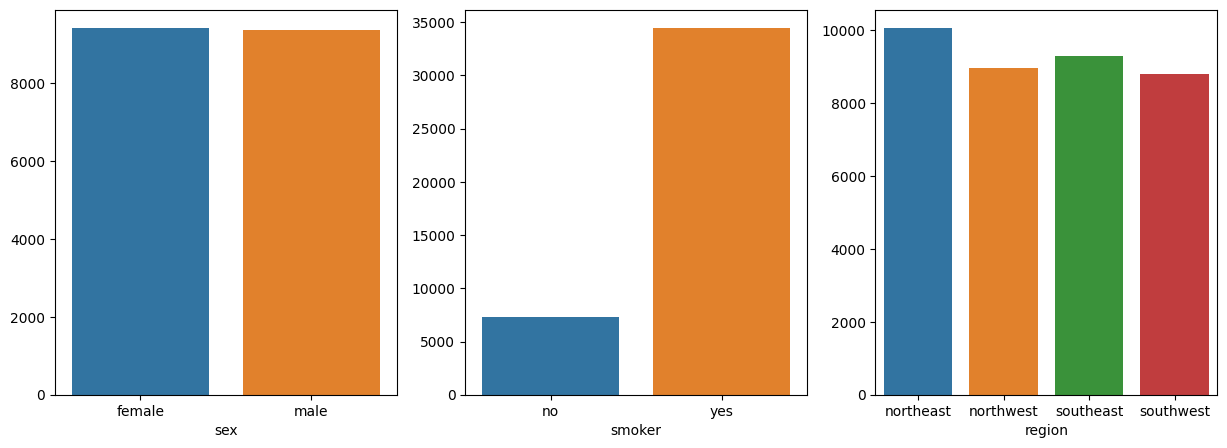

In [42]:
# Строим сводные таблицы по каждому из категориальных признаков:
pivot_sex = data.pivot_table(columns='sex', values='charges', aggfunc='median')
pivot_smoker = data.pivot_table(columns='smoker', values='charges', aggfunc='median')
pivot_region = data.pivot_table(columns='region', values='charges', aggfunc='median')

fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # фигура 1 х 3 координатных плоскостей
#Строим столбчатые диаграммы по полученным сводным таблицам:
barplot1 = sns.barplot(data=pivot_sex, ax=axes[0])
barplot2 = sns.barplot(data=pivot_smoker, ax=axes[1])
barplot3 = sns.barplot(data=pivot_region, ax=axes[2])

диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных

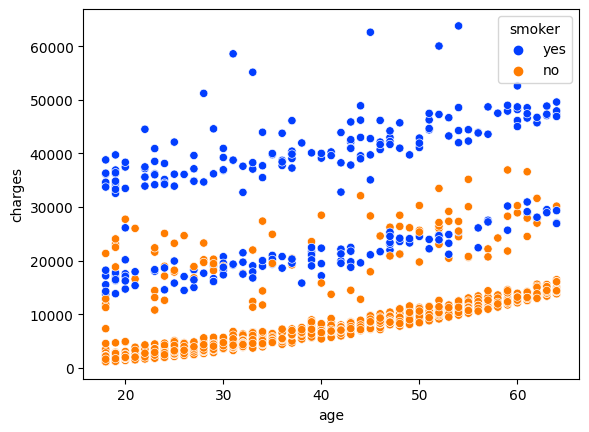

In [48]:
scatterplot = sns.scatterplot(
    data=data, 
    x='age', 
    y='charges',
    hue='smoker',
    palette='bright'
);

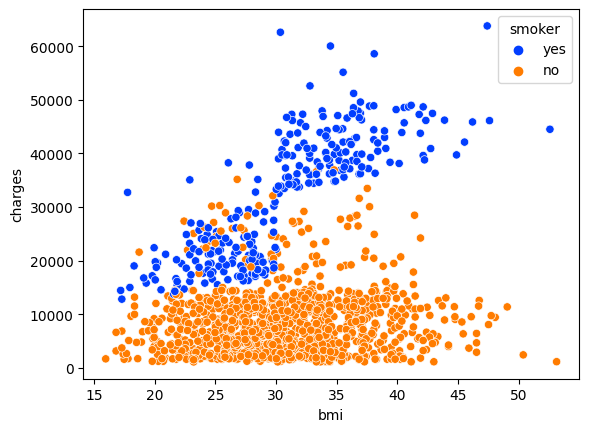

In [52]:
scatterplot = sns.scatterplot(
    data=data, 
    x='bmi', 
    y='charges',
    hue='smoker',
    palette='bright'
);

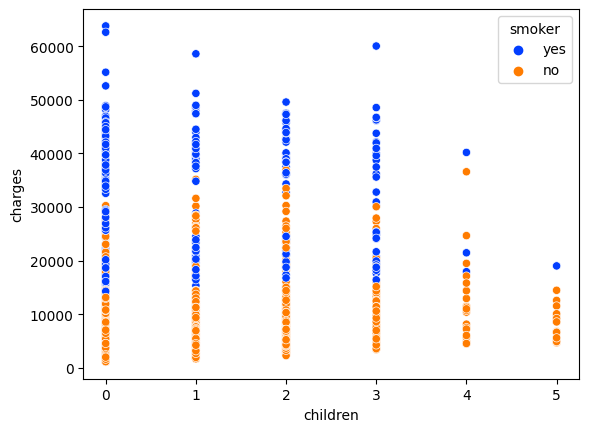

In [54]:
scatterplot = sns.scatterplot(
    data=data, 
    x='children', 
    y='charges',
    hue='smoker',
    palette='bright'
);

## <center> 3. Кодирование признаков

Кодировку будем совершать по следующему принципу:

* smoker — переведём в бинарные значения (0 — некурящий, 1 — курящий);
* sex — аналогично (0 — female, 1 — male);
* region — используем OneHot-кодирование (воспользуемся функцией get_dummies).

In [57]:
#кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
#оставшиеся категориальные признаки кодируем с помощью OneHot
data = pd.get_dummies(data, dtype=int)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


## <center> 4. Построение модели линейной регрессии

Выделим факторы и целевой признак в отдельные таблицы:

In [58]:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

In [59]:
#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [60]:
# Функция для расчёта метрик:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

In [70]:
#Инициализируем объект класса линейная регрессия
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X_train, y_train)
 
print(f'w0: {round(lr_lstat.intercept_, 2)}') #свободный член w0
print('w1: {}'.format(lr_lstat.coef_)) #остальные параметры модели w1, w2, ..., wm

w0: -12390.8
w1: [ 2.56975706e+02 -1.85916916e+01  3.37092552e+02  4.25278784e+02
  2.36511289e+04  4.59585244e+02  8.89079180e+01 -1.98279052e+02
 -3.50214110e+02]


In [71]:
#Делаем предсказание для каждой из выборок
y_train_pred = lr_lstat.predict(X_train)
y_test_pred = lr_lstat.predict(X_test)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


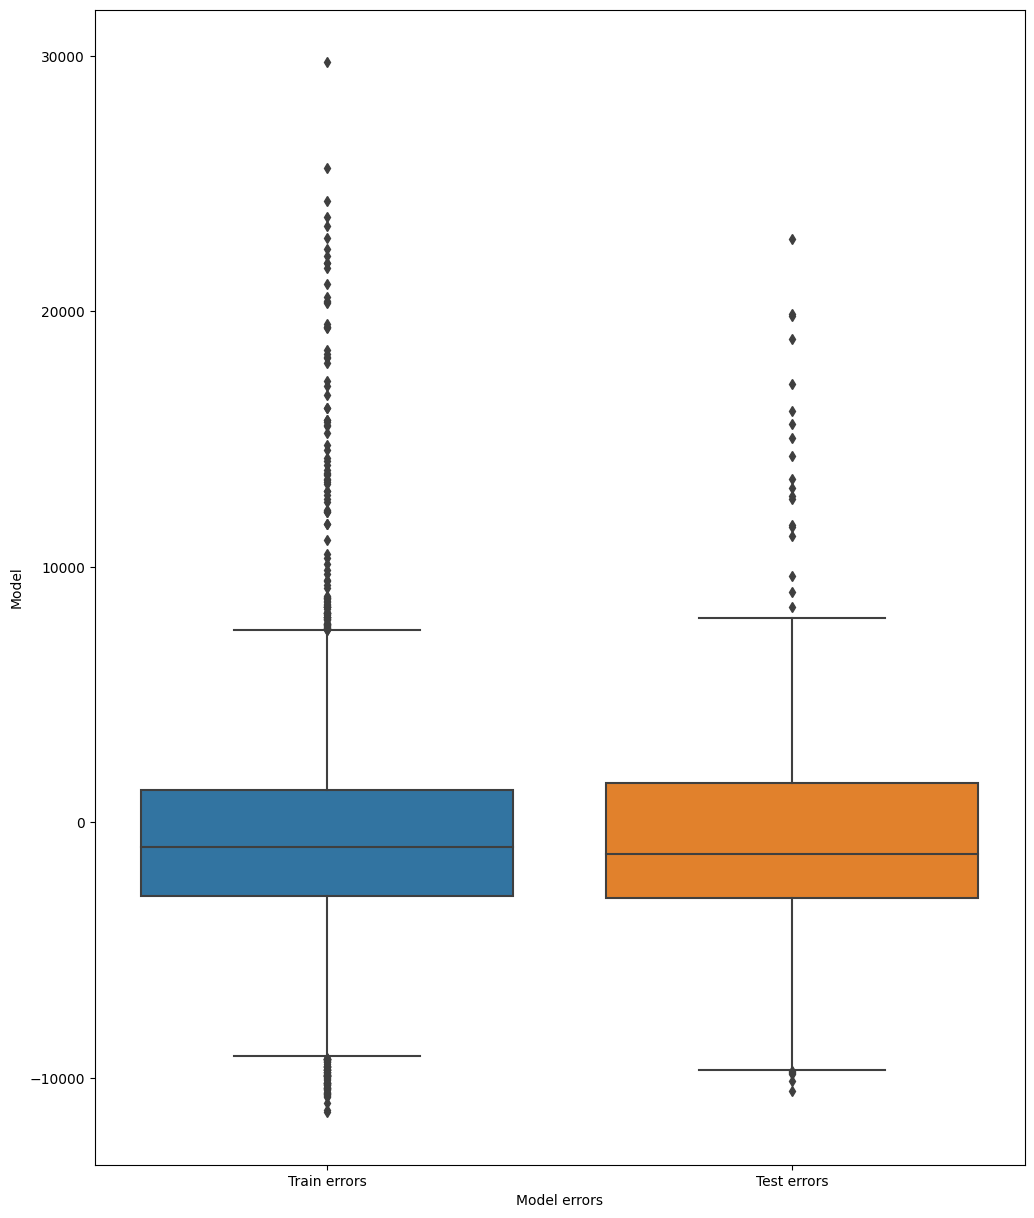

In [75]:
#Визуализируем ошибки
fig, ax = plt.subplots(figsize=(12, 15)) #фигура+координатная плоскость
#Ошибки модели на тренировочной выборке 
y_train_errors = y_train - y_train_pred
#Ошибки модели на тестовой выборке
y_test_errors = y_test - y_test_pred
#Для удобства визуализации составим DataFrame из ошибок
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
#Строим boxplot для ошибок
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors') #название оси абсцисс
ax.set_ylabel('Model'); #название оси ординат

In [77]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [78]:
#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


In [81]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.842
Train MAE: 2897.828
Train MAPE: 29.929


Test R^2: 0.866
Test MAE: 2757.964
Train MAPE: 31.119


In [84]:
# Выводим значения коэффициентов модели.
print(lr_poly.coef_)

[ 1.56066951e+16 -2.36025617e+15 -2.02199036e+16  9.82317926e+15
 -2.94244550e+15 -3.69476050e+16 -1.30603790e+17 -3.95957892e+16
 -5.19089137e+16  8.51800000e+03  7.10000000e+02  1.15300000e+03
 -1.73500000e+03  1.11000000e+02 -1.56066951e+16 -1.56066951e+16
 -1.56066951e+16 -1.56066951e+16  2.02467835e+17  7.16625000e+02
 -1.11343750e+03  1.98312500e+02 -2.00107579e+17 -2.00107579e+17
 -2.00107579e+17 -2.00107579e+17 -9.82328125e+03  1.73112500e+03
  5.48110781e+04  2.02199036e+16  2.02199036e+16  2.02199036e+16
  2.02199036e+16 -2.17600000e+03 -2.19200000e+03 -9.82317926e+15
 -9.82317926e+15 -9.82317926e+15 -9.82317926e+15  4.73680923e+15
 -1.79436372e+15 -1.79436372e+15 -1.79436372e+15 -1.79436372e+15
 -5.78428924e+16  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.58132928e+16  0.00000000e+00  0.00000000e+00 -5.51947081e+16
  0.00000000e+00 -4.28815837e+16]


In [88]:
#Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter = 2000)
#Обучаем модель
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)
#Выводим метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


In [90]:
# Выводим значения коэффициентов модели.
print(lasso_lr_poly.coef_)

[ 3.24221653e+03 -4.92313816e+02  5.07612317e+03  4.58362056e+03
  1.97928569e+03  1.88025707e+02 -4.70775218e+02  5.83657101e+02
 -2.43543456e+02  8.29826751e+03  7.74581954e+02  8.44448593e+02
 -1.20775688e+03  1.34809915e+02 -1.04309726e+03 -0.00000000e+00
  1.16964229e+03  1.61765564e+03 -0.00000000e+00  5.05847740e+02
 -1.13425152e+03  2.65796922e+02 -1.22240479e+03  0.00000000e+00
  2.36213242e+02 -5.80031340e+02 -8.17963257e+03  1.29487768e+03
  5.47148553e+04  3.58531873e+03  2.40690210e+03 -9.63549427e+02
  0.00000000e+00 -1.67464337e+03 -2.05436459e+03  1.94204864e+03
  1.95394442e+03 -0.00000000e+00 -1.06364416e+03  8.00606774e+00
  5.93688978e+02 -0.00000000e+00 -2.30643423e+02  1.97933477e+03
  6.31615519e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.05849873e-01]


In [89]:
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Выводим метрики
print_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380


Итак, лучшие результаты показала модель линейной регрессии на полиноминальных признаках с l1-регуляризацией.

**Цель проекта достигнута.**